In [1]:
import sys, os
script_directory = os.path.abspath('.')
print(script_directory)
sys.path.append(script_directory)

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire\Analysis


In [2]:
# ref 这波是改工作目录，默认为ipynb文件所在目录
os.chdir(os.path.abspath('..'))
print(os.getcwd())
sys.path.append(os.getcwd())

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire


In [3]:
import shap
import packFuncForShap as pack4shap

In [4]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
from itertools import repeat, chain
from functools import partial
import pickle

In [5]:
import importlib
importlib.reload(pack4shap)

<module 'packFuncForShap' from 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire\\Analysis\\packFuncForShap.py'>

In [23]:
evolution_model_path = './model/complete_model'
params_list = os.listdir(evolution_model_path)
date_list = [int(params.rstrip('.pickle')) for params in params_list]
date_list = date_list[::7]

In [14]:
shap_calculates = dict()

for date in date_list:
    print('Iteration date: {date}'.format(date=date))
    path = evolution_model_path + '/{date}.pickle'.format(date=date)

    model = pack4shap.loadModel(path=path)
    modelPredWrapper = partial(pack4shap.modelPredict, model=model, attribute_type='reward')

    dataset = pack4shap.backgroundData(date = date)
    dataset_uni = np.unique(dataset, axis=0)
    print('Data with {k} rows'.format(k=dataset_uni.shape[0]))

    built_bench = np.zeros(model.s_dim).reshape(1, -1)
    locat_bench = np.mean(dataset[:, model.s_dim:], axis=0).reshape(1, -1)
    zero_bench = np.zeros(dataset.shape[1]).reshape(1, -1)
    home_bench = np.hstack((built_bench, locat_bench))

    explainer = shap.PermutationExplainer(modelPredWrapper, home_bench)
    shap_values = explainer(dataset_uni)
    print()
    shap_calculates[date] = shap_values
    with open('./product/shap_results.pickle', 'wb') as f:
        pickle.dump(shap_calculates, f)

Iteration date: 20190707
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190707.pickle!
Data with 183 rows


PermutationExplainer explainer: 184it [17:54,  5.90s/it]                         



Iteration date: 20190714
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190714.pickle!
Data with 194 rows


PermutationExplainer explainer: 195it [17:41,  5.53s/it]                         



Iteration date: 20190721
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190721.pickle!
Data with 206 rows


PermutationExplainer explainer: 207it [18:42,  5.50s/it]                         



Iteration date: 20190729
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190729.pickle!
Data with 211 rows


PermutationExplainer explainer: 212it [19:44,  5.67s/it]                         



Iteration date: 20190805
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190805.pickle!
Data with 230 rows


PermutationExplainer explainer: 231it [22:47,  6.00s/it]                         



Iteration date: 20190812
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190812.pickle!
Data with 237 rows


PermutationExplainer explainer: 238it [23:08,  5.88s/it]                         



Iteration date: 20190819
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190819.pickle!
Data with 246 rows


PermutationExplainer explainer: 247it [22:08,  5.45s/it]                         



Iteration date: 20190827
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190827.pickle!
Data with 249 rows


PermutationExplainer explainer: 250it [22:09,  5.38s/it]                         



Iteration date: 20190903
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190903.pickle!
Data with 261 rows


PermutationExplainer explainer: 262it [23:16,  5.39s/it]                         



Iteration date: 20190910
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190910.pickle!
Data with 273 rows


PermutationExplainer explainer: 274it [24:16,  5.37s/it]                         



Iteration date: 20190917
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190917.pickle!
Data with 279 rows


PermutationExplainer explainer: 280it [24:53,  5.39s/it]                         



Iteration date: 20190927
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20190927.pickle!
Data with 283 rows


PermutationExplainer explainer: 284it [25:15,  5.39s/it]                         



Iteration date: 20191004
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191004.pickle!
Data with 296 rows


PermutationExplainer explainer: 297it [26:20,  5.38s/it]                         



Iteration date: 20191011
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191011.pickle!
Data with 302 rows


PermutationExplainer explainer: 303it [26:46,  5.35s/it]                         



Iteration date: 20191018
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191018.pickle!
Data with 311 rows


PermutationExplainer explainer: 312it [27:34,  5.35s/it]                         



Iteration date: 20191025
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191025.pickle!
Data with 315 rows


PermutationExplainer explainer: 316it [28:00,  5.37s/it]                         



Iteration date: 20191101
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191101.pickle!
Data with 324 rows


PermutationExplainer explainer: 325it [28:45,  5.36s/it]                         



Iteration date: 20191109
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191109.pickle!
Data with 336 rows


PermutationExplainer explainer: 337it [29:55,  5.37s/it]                         



Iteration date: 20191116
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191116.pickle!
Data with 341 rows


PermutationExplainer explainer: 342it [30:19,  5.37s/it]                         



Iteration date: 20191124
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191124.pickle!
Data with 344 rows


PermutationExplainer explainer: 345it [30:42,  5.39s/it]                         



Iteration date: 20191201
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191201.pickle!
Data with 354 rows


PermutationExplainer explainer: 355it [31:34,  5.38s/it]                         



Iteration date: 20191209
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191209.pickle!
Data with 369 rows


PermutationExplainer explainer: 370it [33:00,  5.40s/it]                         



Iteration date: 20191217
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191217.pickle!
Data with 377 rows


PermutationExplainer explainer: 378it [33:37,  5.38s/it]                         



Iteration date: 20191224
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191224.pickle!
Data with 381 rows


PermutationExplainer explainer: 382it [34:00,  5.38s/it]                         



Iteration date: 20191231
(167, 10, 2, 14) (167, 10, 2, 1) (167, 10, 2, 42)
load params from ./model/complete_model/20191231.pickle!
Data with 384 rows


PermutationExplainer explainer: 385it [34:17,  5.39s/it]                         

In [6]:
with open('./product/shap_results.pickle', 'rb') as f:
    shap_calculates = pickle.load(f)

In [7]:
list(shap_calculates.values())

[.values =
 array([[ 0.00000000e+00,  0.00000000e+00, -9.84790921e-03, ...,
         -7.13568926e-03, -3.93676199e-03, -1.31065696e-02],
        [ 0.00000000e+00, -2.30455771e-04, -2.85120755e-02, ...,
         -5.67156756e-02, -1.67228281e-04, -1.76110025e-03],
        [ 0.00000000e+00, -3.37326527e-03, -1.11807808e-02, ...,
          9.89965769e-02,  2.10520227e-02, -4.40716743e-03],
        ...,
        [ 1.05905250e-01, -1.66782867e-02,  7.21421838e-03, ...,
          7.56685454e-02,  1.00443065e-02,  3.80564481e-03],
        [ 1.70105326e-01, -1.42557062e-02, -1.95692442e-02, ...,
         -1.53125416e-01, -2.17137486e-02, -6.77057356e-03],
        [ 1.45994049e-01, -4.70695277e-02,  8.42097844e-03, ...,
         -3.09656826e-02,  2.06398964e-03, -7.82534480e-05]])
 
 .base_values =
 array([-0.32293507, -0.32293507, -0.32293507, -0.32293507, -0.32293507,
        -0.32293507, -0.32293507, -0.32293507, -0.32293507, -0.32293507,
        -0.32293507, -0.32293507, -0.32293507, -0.32293

In [28]:
shap_values = shap_calculates[20190707]

In [8]:
varchr = 'home_distance,LU_Business,LU_City_Road,LU_Consumption,LU_Culture,LU_Industry,LU_Medical,LU_Park_&_Scenery,LU_Public,LU_Residence,LU_Science_&_Education,LU_Special,LU_Transportation,LU_Wild'
varname_BE = varchr.split(',')
varname_PE = ['PE%02d' % i for i in range(6 * len(varname_BE))]
varname = varname_BE + varname_PE
groupmap = {
    'BuiltAttr': varname[:14],
    'Location': varname[14:]
}

In [9]:
def grouped_shap(shap_vals, features, groups):
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))    
    
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

shap_groups = [grouped_shap(shap_vals=shap_values.values, features=varname, groups=groupmap) for shap_values in shap_calculates.values()]


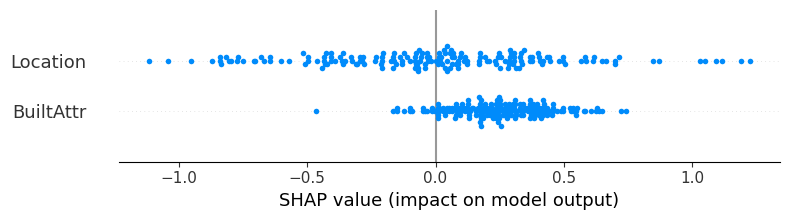

In [21]:
shap.summary_plot(shap_groups[0].values, features=shap_groups[0].columns)

In [41]:
[np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]

[array([0.26544334, 0.34821922]),
 array([0.22709377, 0.31956049]),
 array([0.20212909, 0.27512485]),
 array([0.18119031, 0.25772984]),
 array([0.18313264, 0.25171924]),
 array([0.13666154, 0.22788395]),
 array([0.10710524, 0.2090997 ]),
 array([0.09467388, 0.19354023]),
 array([0.08337173, 0.1752699 ]),
 array([0.07774873, 0.17746285]),
 array([0.07190034, 0.16776664]),
 array([0.06773915, 0.16148704]),
 array([0.06871705, 0.16575081]),
 array([0.06620341, 0.15976782]),
 array([0.06184063, 0.14295139]),
 array([0.05383955, 0.1348622 ]),
 array([0.0516635 , 0.12936071]),
 array([0.04993415, 0.12209753]),
 array([0.04780919, 0.11624306]),
 array([0.04646633, 0.1145877 ]),
 array([0.04656302, 0.10994515]),
 array([0.04943983, 0.11023461]),
 array([0.04761842, 0.10437344]),
 array([0.04844023, 0.10532066]),
 array([0.04700578, 0.10357835])]

In [13]:
ans = [np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]
shap_val = np.array(ans)

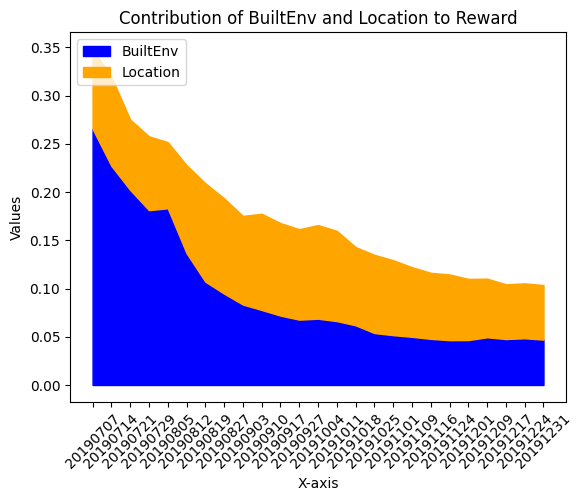

In [28]:
from matplotlib import pyplot as plt

x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_val[:, 0]
y2 = shap_val[:, 1]
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

In [30]:
shap_ratio = shap_val / shap_val.sum(axis=1).reshape(-1, 1)

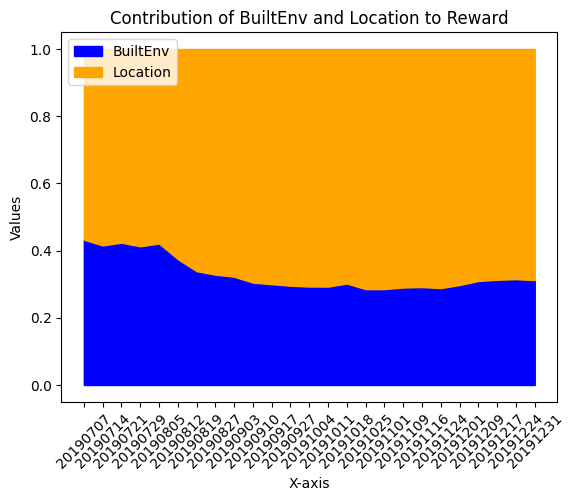

In [31]:
x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_ratio[:, 0]
y2 = np.ones_like(y1)
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

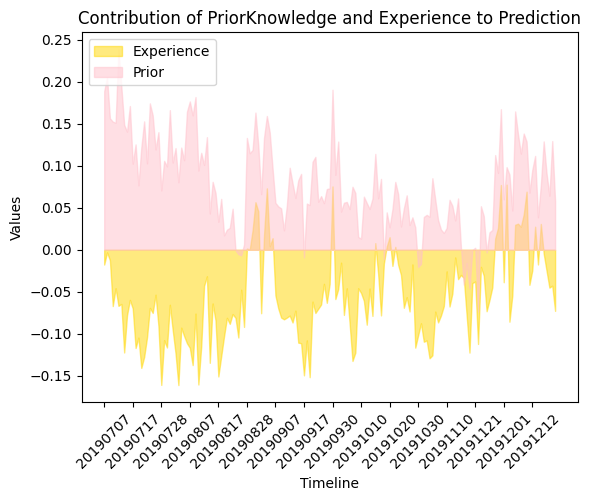

In [42]:
import pandas as pd

df_eval = pd.read_csv('./product/evolution_evaluation.csv')

x = df_eval.index
# 创建图形和轴
fig, ax = plt.subplots()

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

# 绘制堆叠区域
ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of PriorKnowledge and Experience to Prediction')
ax.set_xlabel('Timeline')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x[::10])
labels = [str(d) for d in df_eval.date]
ax.set_xticklabels(labels[::10], rotation=45)

# 显示图表
plt.show()

In [46]:
ax.get_yticklabels()

AttributeError: 'list' object has no attribute 'str'